In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Crank-Nicolson solution zero diffusion across downstream boundary 
#with explicit reaction term that couples concentrations

import pyximport; pyximport.install()

from scipy.linalg import solve_banded
from olm.calcite import concCaEqFromPCO2, createPalmerInterpolationFunctions, palmerRate, calc_K_H,\
                        solutionFromCaPCO2, palmerFromSolution
from olm.general import CtoK



#define parameters for discretization
ntimes = 1000
endtime = 2.0
dt = endtime/(ntimes-1)
nx = 1000
xmax = 1.
dx = xmax/(nx-1.)

#Dimensional parameters
L=1000.#m
D_w = 30.#m^2/s
D_a = 30.
Q_a = -1.#m^3/s
Q_w = 0.1#m^3/s
rho = 2.6#g/cm^3
g_mol_CaCO3 = 100.09
secs_per_year =  3.154e7
pCO2_0 = 5000.*1e-6 #5000 ppm converted to atm
pCO2_outside = 500.*1e-6
T_C=10.
T_K = CtoK(T_C)
K_H = calc_K_H(T_K) #Henry's law constant mols dissolved per atm
Ca_eq_0 = concCaEqFromPCO2(pCO2_0, T_C=T_C)
palmer_interp_funcs = createPalmerInterpolationFunctions(impure=True)

#Arrays of diameters, velocities, and Pe
D_H_w = ones(nx-1)
D_H_a = ones(nx-1)

P_w = D_H_w*np.pi/2.#assumes semi-circular xc
P_a = D_H_a*np.pi/2.

V_w = Q_w/(D_H_w/P_w/4.)#-1
V_a = Q_a/(D_H_a/P_a/4.)#0.1

#Time conversion parameter (between air and water)
T = V_w.mean()/np.abs(V_a.mean())
tau = L/V_w.mean()#Flowthrough time in secs
Pe_a = L*np.abs(V_a)/D_a
Pe_w = L*V_w/D_w

#Reaction/exchange parameters
Lambda_w = 0.5
Lambda_a = Lambda_w*T

#Construct A matrix
A_upper_air = dt*(np.sign(V_a)*1./(4.*dx) - 1./(2.*Pe_a*dx**2.))*ones(nx-1) 
A_lower_air = dt*(-np.sign(V_a)*1./(4.*dx) - 1./(2.*Pe_a*dx**2.))*ones(nx-1)
A_mid_air = (T+dt/(Pe_a*dx**2.))*ones(nx-1) 
A_upper_water = dt*(1./(4.*dx) - 1./(2.*Pe_w*dx**2.))*ones(nx-1) 
A_lower_water = dt*(-1./(4.*dx) - 1./(2.*Pe_w*dx**2.))*ones(nx-1)
A_mid_water = (1.+dt/(Pe_w*dx**2.))*ones(nx-1)

#A_upper = dt*(1./(4.*dx) - 1./(2.*Pe*dx**2.))*ones(nx-1)
#A_lower = dt*(-1./(4.*dx) - 1./(2.*Pe*dx**2.))*ones(nx-1)
#A_mid = (1.+dt/(Pe*dx**2.))*ones(nx-1)
A_upper_air[0] = 0.
A_lower_air[-1] = 0.
if V_a[0]>0:
    A_lower_air[-2] = -dt/(2.*dx)
    A_mid_air[-1] = T + dt/(2*dx)
else:
    A_upper_air[1] = -dt/(2.*dx)
    A_mid_air[0] = T + dt/(2*dx)
    
A_upper_water[0] = 0.
A_lower_water[-1] = 0.
A_lower_water[-2] = -dt/(2.*dx)
A_mid_water[-1] = 1. + dt/(2*dx)

A_air = vstack((A_upper_air, A_mid_air, A_lower_air))
A_water = vstack((A_upper_water, A_mid_water, A_lower_water))

#Create two concentration arrays
C_a = zeros([ntimes,nx])
C_w = zeros([ntimes,nx])
C_Ca = zeros([ntimes,nx])

#Set upstream boundary concentrations
C_a_upstream = pCO2_outside/pCO2_0
C_w_upstream = 1.
C_Ca_upstream = 0.5 #As percent of saturation at reference pCO2 (pCO2_0)

#Set initial conditions for both species
C_a[0,:] = C_a_upstream
C_w[0,:] = C_w_upstream
C_Ca[0,:] = C_Ca_upstream


if V_a[0]>0:
    C_a[:,0] = C_a_upstream
else:
    C_a[:,-1] = C_a_upstream

C_w[:,0] = C_w_upstream
C_Ca[:,0] = C_Ca_upstream

#Create b arrays for each concentration variable
bC_a = zeros(nx-1)
bC_w = zeros(nx-1)
bC_Ca = zeros(nx-1)

for n in arange(ntimes-1):
    print('Timestep=',n)
    #Calculate calcite dissolution rates in
    Ca_mol_L = Ca_eq_0*C_Ca[n,:]
    pCO2_atm = pCO2_0*C_w[n,:]
    sols = solutionFromCaPCO2(Ca_mol_L, pCO2_atm, T_C=T_C)
    print('done creating solutions')
#    Ca_eq_mol_L = concCaEqFromPCO2(pCO2_atm,T_C=T_C)
    #Calculate dissolution rate in mm/yr
#    F = palmerRate(T_C, pCO2_atm, Ca_mol_L/Ca_eq_mol_L, interp_funcs=palmer_interp_funcs)
    F = palmerFromSolution(sols, PCO2=pCO2_atm)
    print('done calculating palmer rates')
    mm_yr_to_mols_sec = 100.*rho/g_mol_CaCO3/secs_per_year/100./(D_H_w/2.)
    #Convert to mols/sec for conduit segment
    R = F[1:]*mm_yr_to_mols_sec
    #Convert to dimensionless Ca
    R_Ca = R*tau/Ca_eq_0
    #Convert to dimensionless pCO2
    R_CO2 = R*tau/K_H/pCO2_0
    
    #Calculate b matrix for C_a
    if V_a[0]>0:
        bC_a[0:-1] = C_a[n,1:-1]*(T-dt/(Pe_a[0:-1]*dx**2.)) + C_a[n,0:-2]*(np.sign(V_a[0:-1])*dt/(4.*dx) + dt/(2.*Pe_a[0:-1]*dx**2.)) \
                        + C_a[n,2:]*(-np.sign(V_a[0:-1])*dt/(4.*dx) + dt/(2.*Pe_a[0:-1]*dx**2.))\
                        - dt*Lambda_a*(C_a[n,1:-1] - C_w[n,1:-1]) #Last line here is added to previous C-N solution to include reaction
        bC_a[0] += dt*(1./(4.*dx) + 1./(2.*Pe_a[0]*dx**2.))*C_a_upstream
        bC_a[-1] = (T-dt/(2.*dx))*C_a[n,-1] + (dt/(2*dx))*C_a[n,-2] - dt*Lambda_a*(C_a[n,-1] - C_w[n,-1])#last term gets added to boundary cond.
    else:
        bC_a[1:] = C_a[n,1:-1]*(T-dt/(Pe_a[1:]*dx**2.)) + C_a[n,0:-2]*(np.sign(V_a[1:])*dt/(4.*dx) + dt/(2.*Pe_a[1:]*dx**2.)) \
                        + C_a[n,2:]*(-np.sign(V_a[1:])*dt/(4.*dx) + dt/(2.*Pe_a[1:]*dx**2.))\
                        - dt*Lambda_a*(C_a[n,1:-1] - C_w[n,1:-1]) #Last line here is added to previous C-N solution to include reaction
        bC_a[-1] += dt*(1./(4.*dx) + 1./(2.*Pe_a[-1]*dx**2.))*C_a_upstream
        bC_a[0] = (T-dt/(2.*dx))*C_a[n,0] + (dt/(2*dx))*C_a[n,1] - dt*Lambda_a*(C_a[n,0] - C_w[n,0])#last term gets added to boundary cond.

    #Calculate b matrix for C_w
    bC_w[0:-1] = C_w[n,1:-1]*(1.-dt/(Pe_w[0:-1]*dx**2.)) + C_w[n,0:-2]*(dt/(4.*dx) + dt/(2.*Pe_w[0:-1]*dx**2.))\
                        + C_w[n,2:]*(-dt/(4.*dx) + dt/(2.*Pe_w[0:-1]*dx**2.))\
                        + dt*Lambda_w*(C_a[n,1:-1] - C_w[n,1:-1])\
                        - dt*R_CO2[0:-1]
    bC_w[0] += dt*(1./(4.*dx) + 1./(2.*Pe_w[0]*dx**2.))*C_w_upstream
    bC_w[-1] = (1.-dt/(2.*dx))*C_w[n,-1] + (dt/(2*dx))*C_w[n,-2] + dt*Lambda_w*(C_a[n,-1] - C_w[n,-1]) - dt*R_CO2[-1]  

    #Calculate b matrix for C_Ca
    bC_Ca[0:-1] = C_Ca[n,1:-1]*(1.-dt/(Pe_w[0:-1]*dx**2.)) + C_Ca[n,0:-2]*(dt/(4.*dx) + dt/(2.*Pe_w[0:-1]*dx**2.))\
                        + C_Ca[n,2:]*(-dt/(4.*dx) + dt/(2.*Pe_w[0:-1]*dx**2.))\
                        + dt*R_Ca[0:-1]
    bC_Ca[0] += dt*(1./(4.*dx) + 1./(2.*Pe_w[0]*dx**2.))*C_Ca_upstream
    bC_Ca[-1] = (1.-dt/(2.*dx))*C_Ca[n,-1] + (dt/(2*dx))*C_Ca[n,-2] + dt*R_Ca[-1]  
    
    
    #Solve systems of equations
    if V_a[0]>0:
        C_a[n+1,1:] = solve_banded((1,1), A_air, bC_a)
    else:
        C_a[n+1,:-1] = solve_banded((1,1), A_air, bC_a)
   
    C_w[n+1,1:] = solve_banded((1,1), A_water, bC_w)
    C_Ca[n+1,1:] = solve_banded((1,1), A_water, bC_Ca)

Timestep= 0
done creating solutions
done calculating palmer rates
Timestep= 1
done creating solutions
done calculating palmer rates
Timestep= 2
done creating solutions
done calculating palmer rates
Timestep= 3
done creating solutions
done calculating palmer rates
Timestep= 4
done creating solutions
done calculating palmer rates
Timestep= 5
done creating solutions
done calculating palmer rates
Timestep= 6
done creating solutions
done calculating palmer rates
Timestep= 7
done creating solutions
done calculating palmer rates
Timestep= 8
done creating solutions
done calculating palmer rates
Timestep= 9
done creating solutions
done calculating palmer rates
Timestep= 10
done creating solutions
done calculating palmer rates
Timestep= 11
done creating solutions
done calculating palmer rates
Timestep= 12
done creating solutions
done calculating palmer rates
Timestep= 13
done creating solutions
done calculating palmer rates
Timestep= 14
done creating solutions
done calculating palmer rates
Times

done calculating palmer rates
Timestep= 123
done creating solutions
done calculating palmer rates
Timestep= 124
done creating solutions
done calculating palmer rates
Timestep= 125
done creating solutions
done calculating palmer rates
Timestep= 126
done creating solutions
done calculating palmer rates
Timestep= 127
done creating solutions
done calculating palmer rates
Timestep= 128
done creating solutions
done calculating palmer rates
Timestep= 129
done creating solutions
done calculating palmer rates
Timestep= 130
done creating solutions
done calculating palmer rates
Timestep= 131
done creating solutions
done calculating palmer rates
Timestep= 132
done creating solutions
done calculating palmer rates
Timestep= 133
done creating solutions
done calculating palmer rates
Timestep= 134
done creating solutions
done calculating palmer rates
Timestep= 135
done creating solutions
done calculating palmer rates
Timestep= 136
done creating solutions
done calculating palmer rates
Timestep= 137
done

done creating solutions
done calculating palmer rates
Timestep= 244
done creating solutions
done calculating palmer rates
Timestep= 245
done creating solutions
done calculating palmer rates
Timestep= 246
done creating solutions
done calculating palmer rates
Timestep= 247
done creating solutions
done calculating palmer rates
Timestep= 248
done creating solutions
done calculating palmer rates
Timestep= 249
done creating solutions
done calculating palmer rates
Timestep= 250
done creating solutions
done calculating palmer rates
Timestep= 251
done creating solutions
done calculating palmer rates
Timestep= 252
done creating solutions
done calculating palmer rates
Timestep= 253
done creating solutions
done calculating palmer rates
Timestep= 254
done creating solutions
done calculating palmer rates
Timestep= 255
done creating solutions
done calculating palmer rates
Timestep= 256
done creating solutions
done calculating palmer rates
Timestep= 257
done creating solutions
done calculating palmer 

done creating solutions
done calculating palmer rates
Timestep= 365
done creating solutions
done calculating palmer rates
Timestep= 366
done creating solutions
done calculating palmer rates
Timestep= 367
done creating solutions
done calculating palmer rates
Timestep= 368
done creating solutions
done calculating palmer rates
Timestep= 369
done creating solutions
done calculating palmer rates
Timestep= 370
done creating solutions
done calculating palmer rates
Timestep= 371
done creating solutions
done calculating palmer rates
Timestep= 372
done creating solutions
done calculating palmer rates
Timestep= 373
done creating solutions
done calculating palmer rates
Timestep= 374
done creating solutions
done calculating palmer rates
Timestep= 375
done creating solutions
done calculating palmer rates
Timestep= 376
done creating solutions
done calculating palmer rates
Timestep= 377
done creating solutions
done calculating palmer rates
Timestep= 378
done creating solutions
done calculating palmer 

done creating solutions
done calculating palmer rates
Timestep= 486
done creating solutions
done calculating palmer rates
Timestep= 487
done creating solutions
done calculating palmer rates
Timestep= 488
done creating solutions
done calculating palmer rates
Timestep= 489
done creating solutions
done calculating palmer rates
Timestep= 490
done creating solutions
done calculating palmer rates
Timestep= 491
done creating solutions
done calculating palmer rates
Timestep= 492
done creating solutions
done calculating palmer rates
Timestep= 493
done creating solutions
done calculating palmer rates
Timestep= 494
done creating solutions
done calculating palmer rates
Timestep= 495
done creating solutions
done calculating palmer rates
Timestep= 496
done creating solutions
done calculating palmer rates
Timestep= 497
done creating solutions
done calculating palmer rates
Timestep= 498
done creating solutions
done calculating palmer rates
Timestep= 499
done creating solutions
done calculating palmer 

done creating solutions
done calculating palmer rates
Timestep= 607
done creating solutions
done calculating palmer rates
Timestep= 608
done creating solutions
done calculating palmer rates
Timestep= 609
done creating solutions
done calculating palmer rates
Timestep= 610
done creating solutions
done calculating palmer rates
Timestep= 611
done creating solutions
done calculating palmer rates
Timestep= 612
done creating solutions
done calculating palmer rates
Timestep= 613
done creating solutions
done calculating palmer rates
Timestep= 614
done creating solutions
done calculating palmer rates
Timestep= 615
done creating solutions
done calculating palmer rates
Timestep= 616
done creating solutions
done calculating palmer rates
Timestep= 617
done creating solutions
done calculating palmer rates
Timestep= 618
done creating solutions
done calculating palmer rates
Timestep= 619
done creating solutions
done calculating palmer rates
Timestep= 620
done creating solutions
done calculating palmer 

done creating solutions
done calculating palmer rates
Timestep= 728
done creating solutions
done calculating palmer rates
Timestep= 729
done creating solutions
done calculating palmer rates
Timestep= 730
done creating solutions
done calculating palmer rates
Timestep= 731
done creating solutions
done calculating palmer rates
Timestep= 732
done creating solutions
done calculating palmer rates
Timestep= 733
done creating solutions
done calculating palmer rates
Timestep= 734
done creating solutions
done calculating palmer rates
Timestep= 735
done creating solutions
done calculating palmer rates
Timestep= 736
done creating solutions
done calculating palmer rates
Timestep= 737
done creating solutions
done calculating palmer rates
Timestep= 738
done creating solutions
done calculating palmer rates
Timestep= 739
done creating solutions
done calculating palmer rates
Timestep= 740
done creating solutions
done calculating palmer rates
Timestep= 741
done creating solutions
done calculating palmer 

KeyboardInterrupt: 

In [116]:
mm_yr_to_mols_sec.shape

(999,)

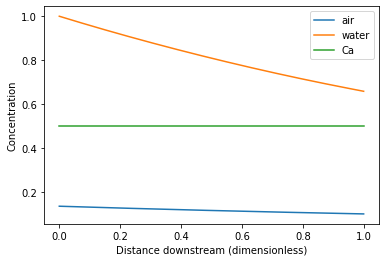

In [3]:
x = linspace(0,1,nx)
plot(x,C_a[750,:])
plot(x,C_w[750,:])
plot(x,C_Ca[750,:])
#plot(x,C_a[160,:])
#plot(x,C_w[160,:])
#plot(x,C_a[260,:])
#plot(x,C_w[260,:])
#plot(x,C_a[360,:])
#plot(x,C_w[360,:])

legend(['air','water', 'Ca'])
#Can compare against previous solution for D
#plot(x,D[200,:],'--')

xlabel('Distance downstream (dimensionless)')
ylabel('Concentration');

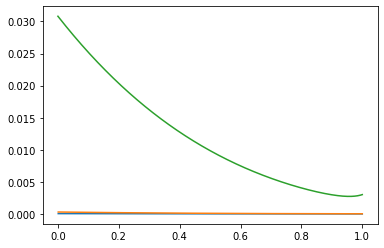

In [128]:
plot(x[1:],R_Ca)
plot(x[1:],R_CO2)
plot(x,F)

